# Exercise 4
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

In [1]:
import os
import sys
import copy
import zipfile
import time
import random
import collections
import numpy as np
from PIL import Image
import pickle
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
%load_ext autoreload
%autoreload 2

1.13.1
cuda


# Recurrent Neural Networks (40 points)

Understanding and implementing the vanilla RNN cell. As you learned in class, the RNN has a certain structure that allows it to accept the previous hidden state the current input, and output an hidden state and an output vector. The RNN cell uses the same weights for all time steps, much like convolution uses the same weights for all the batches in the image. Even though you already are familiar with PyTorch, implementing the RNN you make sure you understand how this pivotal architecture works.

## Helper functions

In [2]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Vanilla RNN: step forward (10 points)

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors less than 1e-7.

In [3]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # TODO: Implement a single forward step for the vanilla RNN. Store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    ##############################################################################
    
    next_h = np.tanh(np.dot(prev_h, Wh) + np.dot(x, Wx) + b)
    cache = (x, prev_h, Wx, Wh, b, next_h)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h, cache

In [4]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward (10 points)

In [5]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a single step of a vanilla RNN.      #
    #                                                                            #
    # HINT: For the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################
    # unpack the cache
    x, prev_h, Wx, Wh, b, next_h = cache
    # compute the local derivative of tanh
    dtanh = 1 - next_h ** 2
    # compute the gradient of the loss with respect to the next hidden state
    dnext_h = dnext_h * dtanh
    # compute the gradient of the loss with respect to the input data
    dx = np.dot(dnext_h, Wx.T)
    # compute the gradient of the loss with respect to the previous hidden state
    dprev_h = np.dot(dnext_h, Wh.T)
    # compute the gradient of the loss with respect to the input-to-hidden weights
    dWx = np.dot(x.T, dnext_h)
    # compute the gradient of the loss with respect to the hidden-to-hidden weights
    dWh = np.dot(prev_h.T, dnext_h)
    # compute the gradient of the loss with respect to the bias vector
    db = np.sum(dnext_h, axis=0)


    
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dprev_h, dWx, dWh, db

In [6]:
np.random.seed(1337)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.2389924368419153e-10
dprev_h error:  1.998548787839473e-08
dWx error:  8.09329219849245e-10
dWh error:  1.0193306662954873e-09
db error:  6.240559767218964e-10


# Vanilla RNN: forward (10 points)
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that process an entire sequence of data.

In [7]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    
    # unpack the shape of the input data
    N, T, D = x.shape # N = batch size, T = sequence length, D = input dimension
    # unpack the shape of the hidden state
    _, H = h0.shape # H = hidden dimension
    # initialize the hidden states for all timesteps
    h = np.zeros((N, T, H))
    # initialize the cache
    cache = []
    # initialize the previous hidden state
    prev_h = h0
    # loop over the timesteps
    for t in range(T):
        # compute the next hidden state
        next_h, cache_t = rnn_step_forward(x[:, t, :], prev_h, Wx, Wh, b)
        # update the hidden states for all timesteps
        h[:, t, :] = next_h
        # update the previous hidden state
        prev_h = next_h
        # update the cache
        cache.append(cache_t)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

In [8]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


# Vanilla RNN: backward (10 points)

In [9]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a vanilla RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above. You can use a for loop to help compute the backward pass.   #
    ##############################################################################

    # unpack the cache
    x, prev_h, Wx, Wh, b, next_h = cache[0]
    # unpack the shape of the input data
    N, T, H = dh.shape
    # unpack the shape of the hidden state
    _, D = x.shape
    # initialize the gradient of the input data
    dx = np.zeros((N, T, D))
    # initialize the gradient of the previous hidden state
    dprev_h = np.zeros((N, H))
    # initialize the gradient of the input-to-hidden weights
    dWx = np.zeros((D, H))
    # initialize the gradient of the hidden-to-hidden weights
    dWh = np.zeros((H, H))
    # initialize the gradient of the bias vector
    db = np.zeros(H)
    # loop over the timesteps in reverse order
    for t in reversed(range(T)):
        # compute the gradient of the loss with respect to the input data, the previous hidden state,
        # the input-to-hidden weights, the hidden-to-hidden weights, and the bias vector
        dx_t, dprev_h, dWx_t, dWh_t, db_t = rnn_step_backward(dh[:, t, :] + dprev_h, cache[t])
        # update the gradient of the input data
        dx[:, t, :] = dx_t
        # update the gradient of the input-to-hidden weights
        dWx += dWx_t
        # update the gradient of the hidden-to-hidden weights
        dWh += dWh_t
        # update the gradient of the bias vector
        db += db_t


    # compute the gradient of the loss with respect to the initial hidden state
    dh0 = dprev_h

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dh0, dWx, dWh, db

In [10]:
np.random.seed(1337)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.464569015986406e-09
dh0 error:  5.581651749890304e-10
dWx error:  3.6889008779825195e-09
dWh error:  8.130385674651184e-09
db error:  5.096074510646251e-10


## Questions

##**Question:** 
When using valina RNN on long sequences, what could happen? What causes this to happen?   **(5 Points)**

**Your answer:**
When using a vanilla RNN on long sequences, there are a few potential issues that can arise. One issue is the problem of vanishing gradients. When the RNN is trying to learn long-term dependencies between elements in the input sequence, the gradients that are used to update the network's weights can become very small. This can make it difficult for the network to learn effectively, and can lead to poor performance on the task at hand.

Another issue that can occur when using a vanilla RNN on long sequences is the problem of exploding gradients. In this case, the gradients that are used to update the network's weights can become very large, which can cause the network's weights to update too quickly and become unstable.

Both of these issues are caused by the fact that vanilla RNNs have a linear activation function in its cell, this makes the gradient of error backpropagated along the time steps compounding as it goes along, on the one hand if it gets too small, then it can be considered as "vanishing" , and if it gets too large, it can be considered as "exploding".

##**Question:** 
Could this problem be solved by a different model? How does it accomplish this?   **(5 Points)**

**Your answer:**
Yes, an example for a model that can solve this is Long Short-Term Memory (LSTM).
it solves this problem by adding a memory cell that is not subject to matrix multiplication or squishing, thereby avoiding gradient decay.
Instead of computing new state as a matrix product with the old state, it rather computes the difference between them.
Expressivity is the same, but gradients are better behaved.

# Building Image Captioning in PyTorch (50 points)

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexability of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network. We only need to provide proper labels to train the new network we created. For this exercise, you will be provided with pretrained networks for both feature extraction and sentence generation, and you will connect the different components needed to make image captioning work.

First, we define the feature extractor and the recurrent model seperately. The feature extractor takes an image and produces a vector representation of the image features. As those features hold information about the image, we will use that vector as the input for our recurrent model. The RNN will produce the image captioning using an LSTM architecture. 

In [11]:
# unzipping the pretrained models
with zipfile.ZipFile(os.path.join('models', 'pretrained_model.zip'), 'r') as zip_ref:
    zip_ref.extractall('models')

In [12]:
# unzipping vocabulary
with zipfile.ZipFile(os.path.join('data', 'vocab.zip'), 'r') as zip_ref:
    zip_ref.extractall('data')

In [13]:
conv_path = 'models/encoder-5-3000.pkl'
lstm_path = 'models/decoder-5-3000.pkl'
vocab_path   = 'data/vocab.pkl'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the following code to check if all the files are in place
print("conv_path ", '✓' if os.path.isfile(conv_path) == True else '✗') 
print("lstm_path ", '✓' if os.path.isfile(lstm_path) == True else '✗') 
print("vocab_path ", '✓' if os.path.isfile(vocab_path) == True else '✗') 

conv_path  ✓
lstm_path  ✓
vocab_path  ✓


## Implementing image captioning model **(40 points)**.

As training a multimodal classifier could take some time and resources, we spared you the training phase this time. In this exercise, we use a pretrained model to solve the image captioning task. Using pretrained models is a common practice in the deep learning community and it's important to be aware of such techniques to save time and energy. In previous cells, we unzipped the necessary files, but in order to be able to load the models (and then use them) it is required to build the same PyTorch model as the pretrained model.

**ConvNet architecture:** resnet152 (without last fc layer) -> fc layer -> BatchNorm1d

**LSTM architecture:** LSTM -> linear -> embed

We added more detailed instructions in the next cells, please make sure you follow them carefully. 

**Please make sure you construct your models based on the sizes we provided.**

In [14]:
embed_size   = 256      # dimension of word embedding vectors
hidden_size  = 512      # dimension of lstm hidden states
num_layers   = 1        # number of layers in lstm

In [15]:
class ConvNet(nn.Module):
    def __init__(self, embed_size):
        super(ConvNet, self).__init__()
        resnet = models.resnet152() # construct an nn.Sequential model without the last resnet152 layer
        # make sure you define each of the None parameters
        self.linear = None
        self.bn = None
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-152 network and replace the top fully          #
        # connected layer, so we could pass the features of the network and not the #
        # classification head which carries significantly less information.         #
        # Afterwards, create a new sequential model which includes the resnet and   #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted embedding. Next, you should add a batchnorm layer with         #
        # momentum=0.01 (BatchNorm1d parameter).                                    #
        # This function has no return value.                                        #
        #############################################################################


        modules = list(resnet.children())[:-1]

        self.resnet = nn.Sequential(*modules)

        # Freeze the weights of the resnet
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the top fully connected layer
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # Add a new fully connected layer that outputs a vector with the size of the wanted embedding
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # perdefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training. Make sure you are inputing a correct shape       #
        # to the batchnorm layer.                                                   #
        # This function returns the features of the image.                          #
        #############################################################################

        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        return features
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################


class LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(LSTM, self).__init__()
        self.max_seg_length = max_seq_length
        self.embed = None
        self.lstm = None
        self.linear = None
        #############################################################################
        # TO DO:                                                                    #
        # Define the hyper-parameters and the layers of the pretrained LSTM.        #
        # Create an Embedding layer that accepts the output of the                  #
        # feature extractor.  Next, the built-in LSTM architecture in PyTorch.nn    #
        # with the proper inputs (use the built-in documentation tool in Jupyter    #
        # or just look at the official documentation online).                       #
        # Define an additional linear layer that comes after the LSTM and outputs   #
        # a vector that will support the size of our vocabulary.                    #
        # This function has no return value.                                        #
        #############################################################################

        # Create an Embedding layer that accepts the output of the feature extractor
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Create an LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Define an additional linear layer that comes after the LSTM
        # and outputs a vector that will support the size of our vocabulary
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################           
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        #############################################################################
        # TO DO:                                                                    #
        # Generate captions for a given image features.                             #
        # First, obtain the output of the LSTM network.        #
        # Next, use the hidden states to obtain the most probable word and store    #
        # all the word predictions in the sampled_ids list. Don't forget to update  #
        # the inputs for each timestep to continue making predictions based on the  #
        # words you are alreaedy predicted.                                         #
        # Make sure you keep track of the dimensions of the inputs and outputs,     #
        # since PyTorch expects tensors with a batch dimension. You can use the     #
        # methods .squeeze() and .unsqueeze()                                       #
        # This function returns the list of predicted words.                        #
        #############################################################################

        # Generate captions for a given image features
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.max(1)[1]
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)

        sampled_ids = torch.stack(sampled_ids, 1)  # (batch_size, max_seq_length)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################        

        return sampled_ids

In [16]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.Resampling.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [18]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [19]:
# Build models
conv = ConvNet(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
lstm = LSTM(embed_size, hidden_size, len(vocab), num_layers)
conv = conv.to(device)
lstm = lstm.to(device)

# Load the trained model parameters
conv.load_state_dict(torch.load(conv_path))
lstm.load_state_dict(torch.load(lstm_path))

# Prepare an image
image_path = os.path.join('data', 'pic.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)

<start> a clock tower with a clock on top of it . <end>


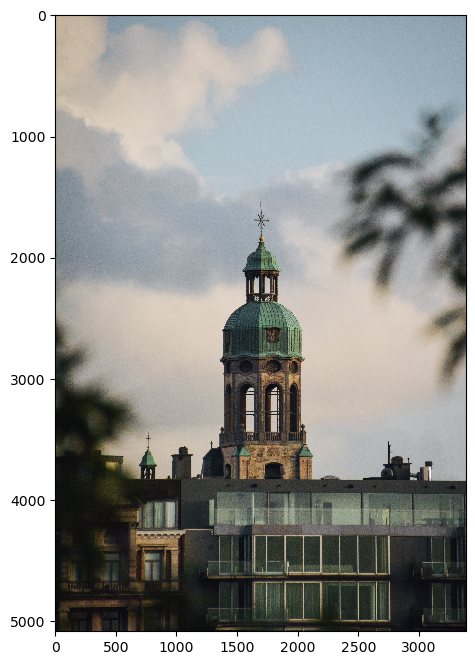

In [20]:
# Generate a caption from the image
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));

## Questions

##**Question:**
Could you think of a method to evalute the goodness of the captioning model? **(5 Points)**

**Your answer:**
Yes, there are several methods to evaluate the goodness of a captioning model:

1 - BLEU Score: BLEU stands for Bilingual Evaluation Understudy, it measures the similarity between predicted and ground-truth captions, by computing n-gram overlap between them.

2 - METEOR Score: METEOR is similar to BLEU but takes into account word alignment and synonymy, it gives higher scores to semantically similar sentences.

3 - ROUGE Score: ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation, it measures the similarity between predicted and ground-truth captions by counting common n-grams.

4 - CIDEr Score: CIDEr is an evaluation metric based on n-gram statistics and rewards completeness and fluency of the caption.

5 - Human Evaluation: This involves human evaluators rating the quality of the generated captions, it is considered the gold standard but can be time-consuming and expensive.

##**Question:** 
Could you think of scenarios where the model fails? Why would that happen? **(5 Points)**

We encourage you to test it on different images (jpg). 

**Your answer:**
Yes, here are a few scenarios where captioning models might fail:

1 - Low-quality images: If the image quality is poor, it can make it difficult for the model to accurately identify and caption the objects in the image.

2 - Unfamiliar objects: The model may struggle to generate captions for objects or scenes it has not seen during training.

3 - Ambiguous scenes: If the scene or image is ambiguous or contains multiple objects with similar appearance, the model might struggle to determine which objects to focus on and generate a caption.

4 - Adversarial examples: If the model is presented with adversarial examples (i.e. manipulated images designed to confuse the model), it may generate incorrect captions.

5 - Limited training data: If the model has limited training data for certain types of scenes or objects, it may struggle to generate captions for these scenarios.

These failures can occur due to limitations in the model's architecture, the quality and quantity of training data, and the model's ability to generalize to unseen examples.